In [9]:
import numpy as np
import torch
import pandas as pd
import sklearn
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.plotting import heatmap
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## coefficient of determination 
from sklearn.metrics import r2_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


import onnxruntime as rt
#import onnxmltools

#from skl2onnx.common.data_types import FloatTensorType

## Parameters


In [10]:

batch_size    = 16
learning_rate = 0.005 ## 0.001
N_Epochs      = 100

epsilon = 0.0001

In [11]:
path_data = "/Users/aidanbeilke/Desktop/Python/pitch_type.csv"

pitch_type_data = pd.read_csv( path_data )

In [12]:
pitch_type_data.shape

(114244, 7)

In [13]:
pitch_type_data = pitch_type_data.dropna()

In [14]:
pitch_type_data.shape

(110674, 7)

In [15]:
pitch_type_data.head()

,Unnamed: 0,pitch_type,release_speed,release_spin_rate,pfx_x,pfx_z,is_lefty
0,3125,CH,90.1,1990.0,-1.53,0.28,0
1,3274,FF,96.7,2189.0,-0.35,1.28,0
2,3413,SL,84.3,2617.0,1.13,0.05,0
3,3580,CH,89.5,2037.0,-1.31,0.41,0
4,3635,SL,84.5,2525.0,0.37,0.20,0


In [16]:
pitch_type_data = pitch_type_data.drop(columns=['Unnamed: 0'])

## Data Analysis

In [17]:
pitch_type_data['pitch_type_code'] = pitch_type_data['pitch_type'].astype('category').cat.codes

pitch_type_data.loc[:, ['pitch_type', 'pitch_type_code']].drop_duplicates().sort_values('pitch_type_code')

,pitch_type,pitch_type_code
0,CH,0
32,CU,1
40,FC,2
1,FF,3
90,FS,4
14,SI,5
2,SL,6
366,ST,7
3678,SV,8


In [18]:
pitch_type_data['pitch_type_code'].astype('category')

0         0
1         3
2         6
3         0
4         6
         ..
114239    4
114240    7
114241    7
114242    3
114243    3
Name: pitch_type_code, Length: 110674, dtype: category
Categories (9, int8): [0, 1, 2, 3, ..., 5, 6, 7, 8]

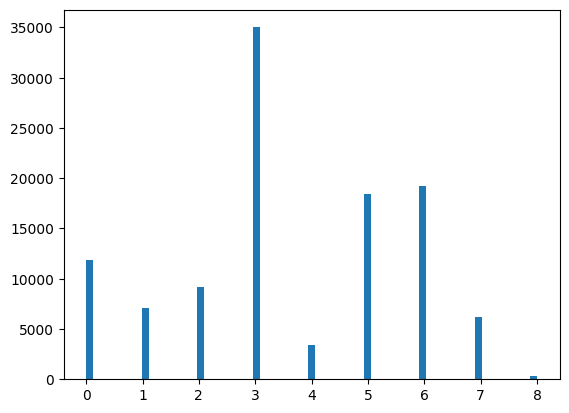

In [19]:
_ = plt.hist( pitch_type_data['pitch_type_code'] , bins="auto" )
plt.show()

In [20]:
min_count = pitch_type_data['pitch_type_code'].value_counts().min()

# Perform undersampling
balanced_pitch_type_data = pitch_type_data.groupby('pitch_type_code').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

/var/folders/z9/0qsxxzxs1hb9r22xy18sfdbc0000gn/T/ipykernel_30771/1925757933.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_pitch_type_data = pitch_type_data.groupby('pitch_type_code').apply(lambda x: x.sample(min_count)).reset_index(drop=True)


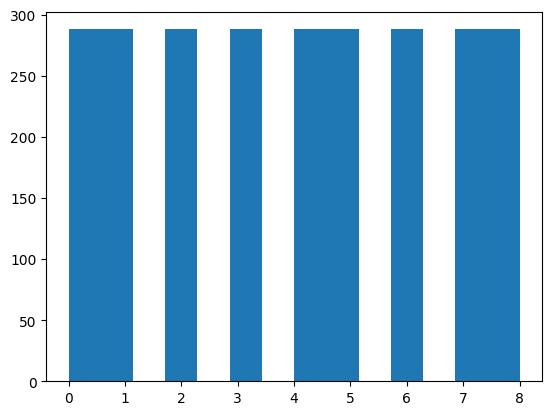

In [21]:
_ = plt.hist( balanced_pitch_type_data['pitch_type_code'] , bins="auto" )
plt.show()

## Process Data

In [22]:
cleaned_pitch_type_data = balanced_pitch_type_data.dropna()

In [23]:

## Convert Pandas to Numpy

pitch_type_data_np = cleaned_pitch_type_data.to_numpy()



In [24]:

pitch_type_data_np


array([['CH', 82.8, 1531.0, ..., -0.02, 1, 0],
       ['CH', 86.5, 1523.0, ..., -0.28, 0, 0],
       ['CH', 86.1, 1336.0, ..., 0.73, 0, 0],
       ...,
       ['SV', 83.3, 2248.0, ..., -0.6, 0, 8],
       ['SV', 81.6, 2799.0, ..., 0.23, 0, 8],
       ['SV', 82.7, 2606.0, ..., -0.18, 0, 8]], dtype=object)

In [25]:
pitch_type_data_np.shape

(2592, 7)

In [82]:

X = pitch_type_data_np[:, 1:6]


y = pitch_type_data_np[:, 6:7]


In [83]:

y


array([[0],
       [0],
       [0],
       ...,
       [8],
       [8],
       [8]], dtype=object)

In [84]:
X

array([[82.8, 1531.0, 1.16, -0.02, 1],
       [86.5, 1523.0, -0.77, -0.28, 0],
       [86.1, 1336.0, -1.07, 0.73, 0],
       ...,
       [83.3, 2248.0, 1.6, -0.6, 0],
       [81.6, 2799.0, 1.43, 0.23, 0],
       [82.7, 2606.0, 1.18, -0.18, 0]], dtype=object)

In [85]:

print(X.shape)

print(y.shape)


(2592, 5)
(2592, 1)


In [86]:

random_seed = int( random.random() * 100 )     ## 42


In [87]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)


In [88]:

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(2073, 5)
(519, 5)
(2073, 1)
(519, 1)


## Change to Float 32



In [89]:
X_train = X_train.astype(  np.float32  )
X_test  = X_test.astype(   np.float32  )

In [90]:
X_train = torch.from_numpy(X_train )
X_test = torch.from_numpy( X_test  )

## Print Shapes

In [91]:
X_train.shape[0]

2073

In [92]:
y_train[203].item()

5

In [93]:

X_train[78]


tensor([7.6100e+01, 2.6540e+03, 1.7600e+00, 4.4000e-01, 0.0000e+00])

In [94]:

CIFAR_train_list = [  ( X_train[i],  y_train[i].item() )  for i in range( X_train.shape[0]   )  ]


In [95]:

CIFAR_test_list = [  ( X_test[i],  y_test[i].item() )  for i in range( X_test.shape[0]   )  ]


## Dataloader

In [96]:
batch_size = 16

In [97]:
train_dl = torch.utils.data.DataLoader( CIFAR_train_list, batch_size=batch_size, shuffle=True  )

In [98]:
test_dl = torch.utils.data.DataLoader( CIFAR_test_list, batch_size=10000, shuffle=True  )

## Architecture

In [99]:


class MLP_net(nn.Module):
    ## init the class
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear( 5 ,20)
        self.act1    = nn.Sigmoid()
        self.linear2 = nn.Linear(20 , 9)
        self.act2    = nn.Softmax(dim=1)
        
    ## perform inference
    def forward(self, x):
        
        x            = self.linear1(x)
        x            = self.act1(x)
        x            = self.linear2(x)
        y_pred       = self.act2(x)
        
        return y_pred


In [108]:
class ComplexMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(5, 128)  
        self.batch_norm1 = nn.BatchNorm1d(128)  
        self.dropout1 = nn.Dropout(0.5) 

        self.linear2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)

        self.linear3 = nn.Linear(64, 32)
        self.batch_norm3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.2)

        self.linear4 = nn.Linear(32, 9)  

    def forward(self, x):
        x = F.relu(self.batch_norm1(self.linear1(x)))
        x = self.dropout1(x)
        x = F.relu(self.batch_norm2(self.linear2(x)))
        x = self.dropout2(x)
        x = F.relu(self.batch_norm3(self.linear3(x)))
        x = self.dropout3(x)
        logits = self.linear4(x)
        
        
        y_pred = F.softmax(logits, dim=1)
        return y_pred


In [101]:

def training_loop( N_Epochs, model, loss_fn, opt ):
    for epoch in range(N_Epochs):
        for xb, yb in train_dl:
            
            ## xb = xb.view(  (16, -1 ) )
            
            y_pred = model(xb)
            
            loss = loss_fn(y_pred, yb)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        if epoch % 5 == 0:
            print(epoch, "loss=", loss)


## Core Functions

In [116]:
N_Epochs      = 300
learning_rate = 0.001

In [117]:


model = ComplexMLP()

opt = torch.optim.Adam(  model.parameters(), lr=learning_rate  )

loss_fn = nn.CrossEntropyLoss()


In [118]:
training_loop( N_Epochs, model, loss_fn, opt )

0 loss= tensor(2.1502, grad_fn=<NllLossBackward0>)
5 loss= tensor(1.9290, grad_fn=<NllLossBackward0>)
10 loss= tensor(1.9444, grad_fn=<NllLossBackward0>)
15 loss= tensor(2.1744, grad_fn=<NllLossBackward0>)
20 loss= tensor(1.6462, grad_fn=<NllLossBackward0>)
25 loss= tensor(1.6615, grad_fn=<NllLossBackward0>)
30 loss= tensor(1.9138, grad_fn=<NllLossBackward0>)
35 loss= tensor(1.6057, grad_fn=<NllLossBackward0>)
40 loss= tensor(1.9092, grad_fn=<NllLossBackward0>)
45 loss= tensor(1.9158, grad_fn=<NllLossBackward0>)
50 loss= tensor(1.9263, grad_fn=<NllLossBackward0>)
55 loss= tensor(2.1666, grad_fn=<NllLossBackward0>)
60 loss= tensor(1.9854, grad_fn=<NllLossBackward0>)
65 loss= tensor(1.5995, grad_fn=<NllLossBackward0>)
70 loss= tensor(1.9257, grad_fn=<NllLossBackward0>)
75 loss= tensor(2.0582, grad_fn=<NllLossBackward0>)
80 loss= tensor(1.9519, grad_fn=<NllLossBackward0>)
85 loss= tensor(1.8736, grad_fn=<NllLossBackward0>)
90 loss= tensor(1.6782, grad_fn=<NllLossBackward0>)
95 loss= tenso

In [119]:


def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('F1-measure: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='weighted'))



In [120]:


with torch.no_grad():
    for x_real, y_real in test_dl:
        
        batch_size = x_real.shape[0]
        
        x_real = x_real.view(  (batch_size, -1 ) )
        
        y_pred = model(  x_real  )
        
        vals, indeces = torch.max( y_pred, dim=1  )
        preds = indeces
        print_metrics_function(y_real, preds)


Accuracy: 0.65
Confusion Matrix:
[[21  0  3  1 14  2  3  0  2]
 [ 0 45  0  0  0  0  6  7  7]
 [ 2  0 38  7  0  0  7  5  2]
 [ 1  0  3 48  0  2  0  0  0]
 [ 8  0  0  0 48  2  0  0  0]
 [ 5  0  1  8  0 47  1  0  0]
 [ 2  3 13  2  1  0 28  8  8]
 [ 3  7  1  0  0  0  4 38  9]
 [ 1  3  0  0  0  0  4 12 26]]
Precision: 0.657
Recall: 0.653
F1-measure: 0.652


In [121]:
model.eval()

dummy_input = torch.randn(1, 5)

input_names  = ["input1"]
output_names = ["output1"]

torch.onnx.export(
        model, 
        dummy_input,
        "Pitch_Type_Model_2.onnx",
        verbose=False,
        input_names = input_names,
        output_names = output_names
        
)
